# Player Unknown Battlegrounds Analysis
'BATTLEGROUNDS is a competitive survival shooter. Players are dropped into a wide, open area, and they must fight to the death - all while the battlefield shrinks, adding pressure to all in its grip. Use a variety of interesting weapons and vehicles amid the BATTLEGROUNDS.'  - https://pubg.gamepedia.com/About 

dataset was gathered from https://www.kaggle.com/lazyjustin/pubgplayerstats

Goal:
- Analysis of gameplay across Solos, Duos and Squads
- Using Machine Learning to predict Elo Rating

### Setup

In [203]:
## All the Libraries used

import os
import numpy as np
import json
import pandas as pd
from collections import Counter
import csv
import matplotlib.pyplot as plt
from sklearn import neighbors, metrics, grid_search, cross_validation
##import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import feature_selection, linear_model
import sklearn
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier



pd.set_option('display.max_rows', 10)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 10)

%matplotlib inline

plt.style.use('ggplot')


In [204]:
## Reading CSV file
data_df = pd.read_csv(os.path.join('~/', 'Desktop','random code','portfolio','PUBG', 'PUBG_Player_Statistics.csv'))

In [205]:
## First 5 rows of the data
data_df.head()

,player_name,tracker_id,solo_KillDeathRatio,solo_WinRatio,solo_TimeSurvived,...,squad_Heals,squad_Revives,squad_Boosts,squad_DamageDealt,squad_DBNOs
0,BreakNeck,4405,3.14,17.65,18469.14,...,2186,234,1884,242132.73,1448
1,Blackwalk,8199,4.41,18.18,33014.86,...,2041,276,2340,269795.75,1724
2,mercedes_benz,4454,3.60,0.00,4330.44,...,1766,210,2193,292977.07,1897
3,DORA,7729,14.00,50.00,13421.82,...,1214,142,1252,181106.90,1057
4,n2tstar,0,10.50,33.33,9841.04,...,1245,120,923,160029.80,1077


In [626]:
## splitting the dataset into solo, duo and squad

stat = data_df[['player_name','tracker_id']]

solo_df = data_df.iloc[:,:52]
duo_df = data_df.iloc[:,53:102]
squad_df = data_df.iloc[:,103:152]

pd.concat([stat, solo_df],axis = 1)
pd.concat([stat, squad_df],axis = 1)
pd.concat([stat, duo_df],axis = 1)

,player_name,tracker_id,duo_WinRatio,duo_TimeSurvived,duo_RoundsPlayed,...,duo_Heals,duo_Revives,duo_Boosts,duo_DamageDealt,duo_DBNOs
0,BreakNeck,4405,33.33,21913.81,15,...,35,2,43,8544.07,40
1,Blackwalk,8199,35.71,17765.43,14,...,27,2,43,4744.32,23
2,mercedes_benz,4454,35.29,23449.22,17,...,28,2,42,8972.61,36
3,DORA,7729,66.67,4196.37,3,...,1,1,6,1302.40,5
4,n2tstar,0,25.71,142571.50,105,...,199,26,235,45005.56,216
...,...,...,...,...,...,...,...,...,...,...,...
87893,SaikoMene,87710,7.14,24717.99,28,...,57,2,24,3112.14,18
87894,KARUKOR,22783,0.00,22581.61,22,...,37,6,22,5436.55,21
87895,Dertydann,178547,2.54,112808.56,118,...,193,15,87,16135.20,64
87896,Neferhor,126589,17.74,311229.68,248,...,512,55,510,100159.51,460


### Exploratory Analysis: Overall

In [744]:
## Stats across Solo, Duo and Squad
print 'Win Rate'
print 'Squad',(squad_df['squad_Wins']/squad_df['squad_RoundsPlayed']).mean()
print 'Duo',(duo_df['duo_Wins']/duo_df['duo_RoundsPlayed']).mean()
print 'Solo',(solo_df['solo_Wins']/solo_df['solo_RoundsPlayed']).mean() , '\n'

print 'Average Surival Time'
print 'Squad',(squad_df['squad_AvgSurvivalTime']).mean()
print 'Duo',(duo_df['duo_AvgSurvivalTime']).mean()
print 'Solo',(solo_df['solo_AvgSurvivalTime']).mean() , '\n'

print 'Amount Healed'
print 'Squad',(squad_df['squad_Heals']).mean()
print 'Duo',(duo_df['duo_Heals']).mean()
print 'Solo',(solo_df['solo_Heals']).mean() , '\n'

print 'Amount Boosted'
print 'Squad',(squad_df['squad_Boosts']).mean()
print 'Duo',(duo_df['duo_Boosts']).mean()
print 'Solo',(solo_df['solo_Boosts']).mean(), '\n'

Win Rate
Squad 0.0630152915061
Duo 0.0464294114954
Solo 0.0501757706719 

Average Surival Time
Squad 1041.52042583
Duo 996.29537498
Solo 996.532800974 

Amount Healed
Squad 345.853147967
Duo 195.035825616
Solo 110.544426494 

Amount Boosted
Squad 226.072345218
Duo 140.543425334
Solo 102.052094473 



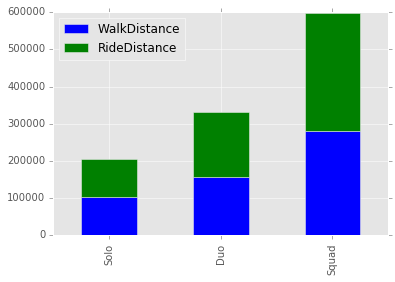

In [734]:
## Move Distance stats across Solo, Duo and Squad
c = pd.DataFrame(index = ['Solo','Duo','Squad'])
c['WalkDistance'] = 0.00
c['RideDistance'] = 0.00

c['WalkDistance'][0] = solo_df['solo_WalkDistance'].mean()
c['RideDistance'][0] = solo_df['solo_RideDistance'].mean()

c['WalkDistance'][1] = duo_df['duo_WalkDistance'].mean()
c['RideDistance'][1] = duo_df['duo_RideDistance'].mean()

c['WalkDistance'][2] = squad_df['squad_WalkDistance'].mean()
c['RideDistance'][2] = squad_df['squad_RideDistance'].mean()

c.plot(kind = 'bar',stacked = True)

- Total distance travelled increases as player's group inrease.
- Duos and Squads travel more on vehicles

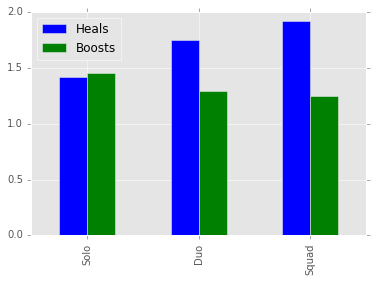

In [750]:
## Healing and Boosting stats across Solo, Duo and Squad
d = pd.DataFrame(index = ['Solo','Duo','Squad'])
d['Heals'] = 0.00
d['Boosts'] = 0.00

d['Heals'][0] = solo_df['solo_HealsPg'].mean()
d['Boosts'][0] = (solo_df['solo_Boosts']/solo_df['solo_RoundsPlayed']).mean()

d['Heals'][1] = duo_df['duo_HealsPg'].mean()
d['Boosts'][1] = (duo_df['duo_Boosts']/duo_df['duo_RoundsPlayed']).mean()

d['Heals'][2] = squad_df['squad_HealsPg'].mean()
d['Boosts'][2] = (squad_df['squad_Boosts']/squad_df['squad_RoundsPlayed']).mean()

d.plot(kind = 'bar')

- Amount of Heals used increases across group size
- This may be explained by the healing done after getting downed and revived
- Although the amount of boosts used decreases

### Exploratory Analysis: Solo

In [208]:
## Unlike other modes, Solo does not have TeamKills or Revives, thus having it would be redundant 
solo_df.drop(['solo_Revives'], inplace = True, axis = 1)
solo_df.drop(['solo_RevivesPg'], inplace = True, axis = 1)
solo_df.drop(['solo_TeamKillsPg'], inplace = True, axis = 1)
solo_df.drop(['solo_TeamKills'], inplace = True, axis = 1)


In [209]:
## Sorting 10 highest correlated stats
c = solo_df.corr().abs()

s = c.unstack()
so = s.order(kind="quicksort", ascending = False)

so = so.dropna()
sso = pd.DataFrame(so)

sso[0][[49,51,53,55,57,59,61,63,65,67]]

/Users/daweitan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: order is deprecated, use sort_values(...)


solo_Losses         solo_RoundsPlayed    0.999484
solo_DamageDealt    solo_Kills           0.996532
solo_BestRating     solo_Rating          0.989580
solo_DamagePg       solo_KillsPg         0.983191
solo_TimeSurvived   solo_WalkDistance    0.971632
solo_MoveDistance   solo_RideDistance    0.967626
solo_TimeSurvived   solo_RoundsPlayed    0.964805
solo_Losses         solo_TimeSurvived    0.960108
solo_MoveDistance   solo_TimeSurvived    0.960032
solo_HeadshotKills  solo_Kills           0.952859
Name: 0, dtype: float64

(0, 4000)

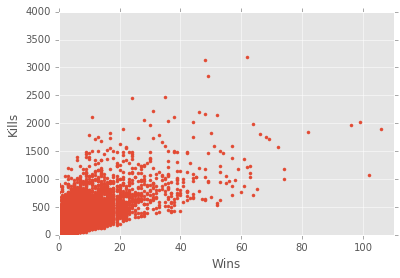

In [684]:
## plot: Wins vs Kills 
plt.plot(solo_df['solo_Wins'],solo_df['solo_Kills'],'.')
plt.xlabel('Wins')
plt.ylabel('Kills')

plt.xlim(0, 110)
plt.ylim(0, 4000)

- Zero Kill wins seem to only occur when players have less than 10 wins

y=0.569005x+(-14791.403988)


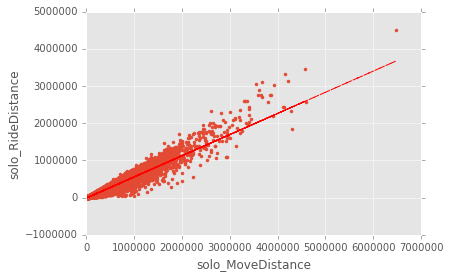

In [703]:
## plot: Move Distance vs Ride Distance
plt.plot(solo_df['solo_MoveDistance'], solo_df['solo_RideDistance'] ,'.')
plt.xlabel('solo_MoveDistance')
plt.ylabel('solo_RideDistance')

z = np.polyfit(solo_df['solo_MoveDistance'], solo_df['solo_RideDistance'], 1)
p = np.poly1d(z)
plt.plot(solo_df['solo_MoveDistance'],p(solo_df['solo_MoveDistance']),"r--")

print "y=%.6fx+(%.6f)"%(z[0],z[1])

-  Since you cannot have more Ride Distance than Move Distance, all the data points are on or below X=Y.

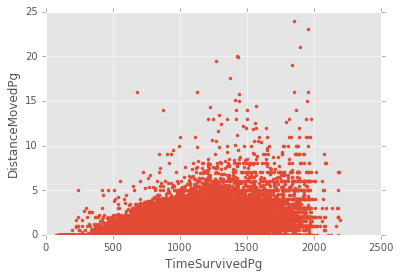

In [639]:
## plot: Time Survived Per Game vs Heals Per Game
plt.plot(solo_df['solo_TimeSurvivedPg'], solo_df['solo_HealsPg'] ,'.')
plt.xlabel('TimeSurvivedPg')
plt.ylabel('DistanceMovedPg')

- Obviously as you survive longer, there will be more fighting and healing 
- There are also the pacifist players, who usually avoid other players and fights, thus require less healing and stays alive longer.

## Rating vs Linear Regression
Since Elo Rating sits on a continuous scale, Linear Regression would be the best method in mimicking Elo Rating system. Although Linear Regression won't produce results that match Elo Ration 100%, it will give a good understanding of how the model weighs different variables in order to match and predict Elo Rating

I will be using Solo's Rating and Solo's stats to calculate the model. I decided to use correlation between Solo_Rating and variables to select which features to use because this is the most straight forward approach to selecting features.

### Linear Regression: Creating model

In [558]:
## making a copy of the dataset for Solo games
solo_pred = solo_df.copy()

## dropping columns that have no effect on rating
solo_pred = solo_pred.drop('solo_DBNOs', axis = 1)
solo_pred = solo_pred.drop('solo_WeaponAcquired', axis = 1)
solo_pred = solo_pred.drop('player_name', axis = 1)
solo_pred = solo_pred.drop('tracker_id', axis = 1)

## making train and test set (not using train test split function since this version of sklearn is older)
msk = np.random.rand(len(solo_pred)) <= 0.7

train = solo_pred[msk]
test = solo_pred[~msk]

In [559]:
## splitting train and test set into its relative X and Y values
y = train['solo_Rating']
X = train.drop('solo_Rating',axis = 1)
X = X.drop('solo_BestRating',axis = 1)


test_X = test.drop('solo_WinRatio',axis = 1)
test_X = test_X.drop('solo_BestRating',axis = 1)

test_y = test['solo_Rating']

In [560]:
## finding the correlation between rating and the rest of the columns and sorting based on correlation
sup = train.corr()['solo_Rating'].order(kind="quicksort", ascending = False)
sup = sup.drop('solo_BestRating')

/Users/daweitan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: order is deprecated, use sort_values(...)
  from ipykernel import kernelapp as app


In [561]:
## creating a DataFrame to store rsquared and P values
ols_df = pd.DataFrame(index = range(1,49))
ols_df['rsquared'] = 0.00
ols_df['pvalue'] = 0.00

In [562]:
## calculating rsquared and P values for Linear Regressions with different amount of features
for x in range(2,49):
    a = sm.OLS(y,X[list(sup.index)[1:x]]).fit()
    ols_df['rsquared'][x] = a.rsquared
    ols_df['pvalue'][x] = a.pvalues.mean()
    
ols_df = ols_df.drop(1, axis = 0)

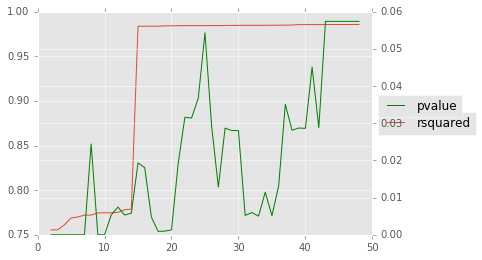

,rsquared,pvalue
12,0.775179,0.007447
13,0.778101,0.005328
14,0.778806,0.005797
15,0.983613,0.019333
16,0.983613,0.018044
17,0.983638,0.004750
18,0.983638,0.000927
19,0.984051,0.000993
20,0.984065,0.001317
21,0.984281,0.019177


In [572]:
## plotting rsquared and P values based on number of features
x = ols_df.index

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot(x, ols_df['rsquared'])
ax2.plot(x, ols_df['pvalue'],'-g')
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax2.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()

ols_df[10:20]

- The graph shows that after 14 features, the R squared value suddenly increased to around .98
- Whereas for the P values, although it fluctuates up and down, there's still a rising trend
- Therefore, for further analysis, I am using the highest R squared value and the lowest average P value
- This means the Linear Regression model consists of 18 features that are most correlated with solo_Rating

In [576]:
model = sm.OLS(y,X[list(sup.index)[1:19]]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            solo_Rating   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                 2.381e+05
Date:                Wed, 18 Oct 2017   Prob (F-statistic):               0.00
Time:                        15:47:43   Log-Likelihood:            -4.2286e+05
No. Observations:               61762   AIC:                         8.458e+05
Df Residuals:                   61746   BIC:                         8.459e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
solo_Days                    5.6546      0.112     50.314      0.000         5.434     5.875
solo_Top10s                 -3.0813      0.281    -10.973      0.000        -3.632    -2.531
solo_Boosts                  0.3008      0.025     12.243      0.000         0.253     0.349
solo_TimeSurvived            0.0039      0.000     32.008      0.000         0.004     0.004
solo_WalkDistance           86.3015     18.576      4.646      0.000        49.892   122.710
solo_MoveDistance          -86.3012     18.576     -4.646      0.000      -122.710   -49.892
solo_DamageDealt             0.0102      0.001      8.616      0.000         0.008     0.013
solo_Kills                  -0.4054      0.128     -3.156      0.002        -0.657    -0.154
solo_Assists                -0.7938      0.324     -2.454      0.014        -1.428    -0.160
solo_RideDistance           86.3010     18.576      4.646      0.000        49.892   122.710
solo_Heals                  -0.0482      0.015     -3.188      0.001        -0.078    -0.019
solo_RoundsPlayed           -0.8407      0.209     -4.030      0.000        -1.250    -0.432
solo_Losses                 -2.1917      0.192    -11.400      0.000        -2.569    -1.815
solo_MostSurvivalTime        0.3809      0.001    584.047      0.000         0.380     0.382
solo_LongestTimeSurvived     0.3809      0.001    584.047      0.000         0.380     0.382
solo_HeadshotKills          -1.3682      0.107    -12.819      0.000        -1.577    -1.159
solo_Wins                    1.3510      0.395      3.417      0.001         0.576     2.126
solo_LongestKill             0.3533      0.009     39.990      0.000         0.336     0.371
==============================================================================
Omnibus:                     5594.108   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20758.797
Skew:                           0.416   Prob(JB):                         0.00
Kurtosis:                       5.716   Cond. No.                     1.90e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.99e-23. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Linear Regression: Predicting Solo_Rating

In [578]:
## creating a DataFrame with test set's solo_Rating as a column
test_df = pd.DataFrame(data = test_y[:])

## using predict() to predict solo_Rating
model_test = model.predict(test_X[list(sup.index)[1:19]])

## inserting predicted Rating into DataFrame
test_df['pred_val'] = model_test[:]

## Resetting index
test_df.reset_index(inplace = True)
test_df = test_df.drop('index', axis = 1)

## calculating difference between solo_Rating and predicted rating
test_df['diff'] = test_df['solo_Rating'] - test_df['pred_val']

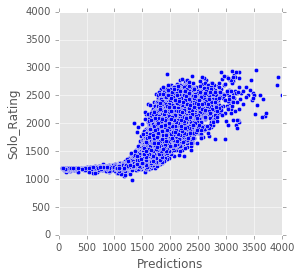

In [676]:
## plot: solo_Rating vs predicted rating
plt.scatter(test_df['pred_val'], test_df['solo_Rating'])
plt.ylabel('Solo_Rating')
plt.xlabel('Predictions')

plt.xlim(0, 4000)
plt.ylim(0, 4000)
plt.gca().set_aspect('equal', adjustable='box')

- First thing I noticed was the predictions started from 0, whereas Solo_Rating started around 1100.
- Around 1300 is where the model starts to get more "accurate" predictions
- The highers the Rating, the more scattered the predictions were.

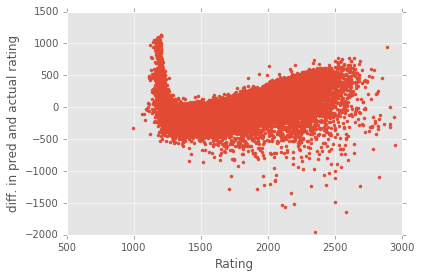

In [597]:
## plot: difference vs solo_Rating
## graph is sorted from lowest rating to highest
sort = test_df.sort_values(by = 'solo_Rating')

sort.reset_index(inplace = True)
sort = sort.drop('index', axis = 1)

plt.plot(sort['solo_Rating'], sort['diff'], '.')
plt.xlabel('Rating')
plt.ylabel('diff. in pred and actual rating')

 - As mentioned above, there's a huge disparity in Solo_Rating and prediction towards the lower end of the Rating
 - As you go up the Rating, the model consistently under estimate predictions, yet there are rarely any anomoly 
 - However, the model consistently over estimates predictions in a messy fashion

### Linear Regression: Adding a Constant
#### One reason that the model does not perform well at low Solo_Ratings might be because the model does not take y-intercept(base coefficient) into consideration; meaning there might exist a lowest possible Solo_Rating. Thus, one way to improve the model is to include a constant, which is selected using the lowest Solo_Rating.

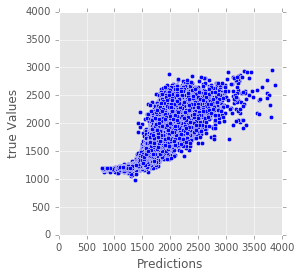

In [789]:
## Adding a Constant column
hue = sm.add_constant(X[list(sup.index)[1:19]])

## Setting the Constant column to the minimum Solo_Rating
hue['const'] = y.min()

## Creating Linear Regression model
model_const = sm.OLS(y, hue).fit()

## Adding and Setting Constant column for test set
huehue = sm.add_constant(test_X[list(sup.index)[1:19]])
huehue['const'] = test_y.min()

## plot: solo_Rating vs predicted rating WITH CONSTANT
plt.scatter(model_const.predict(huehue), test_y)
plt.ylabel('true Values')
plt.xlabel('Predictions')

plt.xlim(0, 4000)
plt.ylim(0, 4000)
plt.gca().set_aspect('equal', adjustable='box')

- Though the overall shape of the graph remained the same, predictions at lower Ratings gave better results

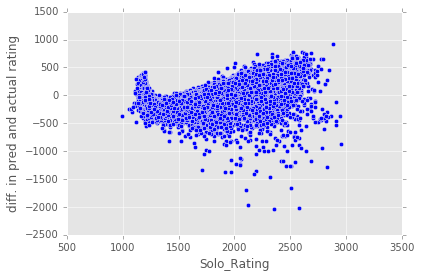

In [790]:
## plot: difference vs solo_Rating WITH CONSTANT
plt.scatter(test_y, (test_y - model_const.predict(huehue)))
plt.ylabel('diff. in pred and actual rating')
plt.xlabel('Solo_Rating')

 - The same goes for this graph, which looks at the difference in prediction and Solo_Rating

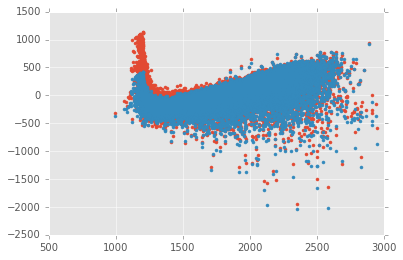

In [791]:
## Plot: Before vs After Adding a Constant
## RED Scattered plot: difference vs solo_Rating
## BLUE Scattered plot: difference vs solo_Rating WITH CONSTANT
plt.plot(sort['solo_Rating'], sort['diff'], '.')
plt.plot(test_y,(test_y - model_const.predict(huehue)), '.')
plt.show()

- It's apparent that adding a constant improves the accuracy of the model when predicting lower Ratings without sacrificing the overall accuracy of the model

### Summary

#### Exploratory Analysis:
- Players usually have highest winrate as Squard, and lowest winrate as Duo
- Moreover, when playing Squad, players usually travel further, whether it's for loot or better positioning
- With the mechanis of downed players and picking up players, Squads and Duos use more healing and boosters than Solos

#### Linear Regression:
- Using top 19 features that were most correlated with Solo_Rating produced the "best" model
- "best" meaning highest t value and lowest p values
- The model created usually predict with accuracy of +/-500.
- When it over estimates, it's mainly between 0 and 500
- when it under estimates, as the rating increases, the degree of under estimation increases.

Overall, I can say that my Linear Regression model can predict PUBG's Solos Rating with a +/-500 accuracy. Since I don't know how their Elo Rating weighs each feature, I could only guess through its correlation. Moreover, the Linear Regression Model only tries to fit the model as best as it can with the given data, thus the model's interpretation of important features will be different to the actual heavily weighted features.